# Face Recognition

### !!This is a basic notebook, completing which you can get (preliminarly) 5/10 ponints. Other tasks which will get you more ponts are described in a Telegram chat

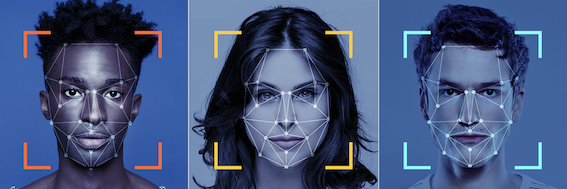

In this project you'll dive into face recognition framework and train neural network for face recognition task, play with losses and metrics.

We will train neural network on [CelebA dataset](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). 

As you see on the site, images of celebA dataset look like this:


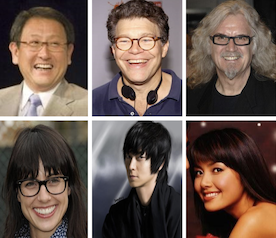

But we won't train a neural network for face recognition on those images. We'll need to preprocess them first. Let's see why we need it and how we need to preprocess them.

Let's look at how face recognition systems work:

## Face recognition model training and inference setup

This section describes how face recognition models are trained, what data alignment is and how the inference of face recognition model looks like. If you are familiar with this, you can skip this section.

### Model training

To train face recognition model on any facial dataset images must be aligned first. This step is very important to achieve a good quality of face recognition.

What is alignment: it consists of three steps:
1. Given image, identify facial landmarks on the image (coordinates of eyes, nose and mouth points). Separate neural network can be used there which was trained to identify landmarks on facial images. You can refer to [PyTorch Landmarks tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) to see how this works.
2. Rotate all the images in the dataset so that eyes of the person on every image lie on a certain pre-defined horizontal line.
3. Scale all the images in the dataset so that the size of the faces are approximately identical.

Here's an example of what we would get after alignment of all the images of Aaron Peirsol from our dataset:

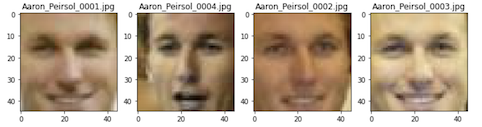

You see that eyes of all the faces lie on one horizontal line and all the faces have almost the same size. If we align all the images in the dataset, we can then train a neural network on aligned images.

**Why we need the alignment procedure**: the alignment of all faces in dataset makes the task of facial recognition easier for the model. If all the faces that model sees are of the same size and have their landmarks (eyes, nose, etc) on almost the same parts of the images, it is easier for the model to learn to identify a person on the image. The model diesn't need to "search" for the face and eyes positions on the image befire performing a recognition.

If you are interested, you can also train a model on non-aligned images, but you'll see that it would perform badly. It is possible though to train a model for face recognition without pre-alignment of all the faces, but this would require a huge amount of data — more that almost any company has. The only company that has openly presented its face recognition system that does not require special alignment is Facebook — their neural network was trained on a really huge amount of data using a special trick to avoid alignment. You can read more details [here](https://research.fb.com/publications/deepface-closing-the-gap-to-human-level-performance-in-face-verification/)

### Model inference

So let's see how the model trained on aligned faces can be used in real world:

Let's assume you owe a company and you want to build a face recognition system for your working office. You decided to hang some cameras around the office and want them to be able to recognize faces of all your employees when they are sitting / walking around the office (we let you decide by yourself why you would need such a system in your office)


A system for face recognition typically conststs of 3 stages:
- face detection
- face alignment
- face recognition

Let's discuss them in detail:

**Face detection**

When the camera is hanged on the wall it records a video and splits the video into single images, like this:

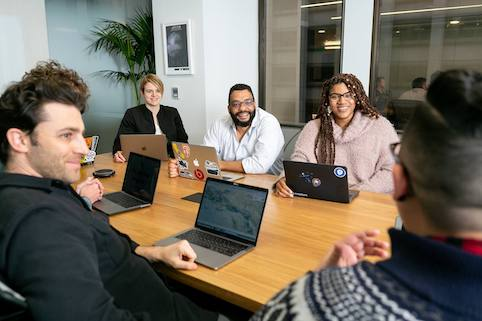

To be able to recognize all the faces on the photo you need first to detect all the faces that are present on the photo, like this:

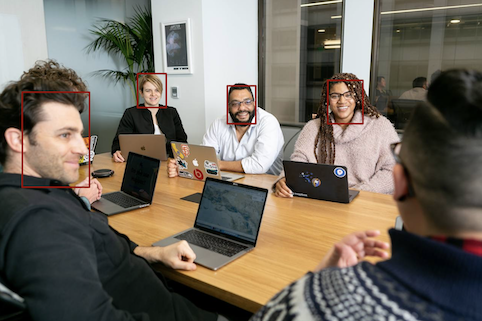

That is the first part — detection. You could use any neural network that can detect humans for this.

**Face alignment**

The second stage is to align all the faces found. The alignment procedure here should be the same as used to align training images.

So we'll get an image of a guy on a photo aligned like this:

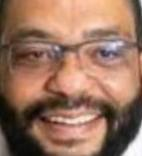

**Face recognition**

On the third stage we use the neural network that we trained to recognize a face.

So that's how the face recognition models pipeline work. You can also read about it more on [this link](https://www.nytimes.com/wirecutter/blog/how-facial-recognition-works/) (and using internet search)

## Neural network model architecture 

Let's discuss how model for face recognition should look like.



The easiest and, actually, the most used way to build a neural network for face recognition is to build it as a **simple classifier**.

Assume we have a dataset with photos of N different people. Then we can build a neural network to classify all the images from the dataset into N classes. Each class refers to one unique person in the dataset.

**How do we recognize new people by this network then?** We actually want the network for face recognition to be able to recognize not only the people which are in training set, but almost every person in the world.

That is how: after training the model, we'll drop it's last classification layer. After that when we'll pass an image of the person through network, we'll get the output of the pre-last layer — it's **the embedding of the image**. Having embeddings of two different images we can compare them using **cosine distance**. The less the distance is — the higher the probability that those two photos belong to one person is. 

Using that technique we can get embeddings of every image — even of unseen people, compare them, and reveal images belonging to same people. 

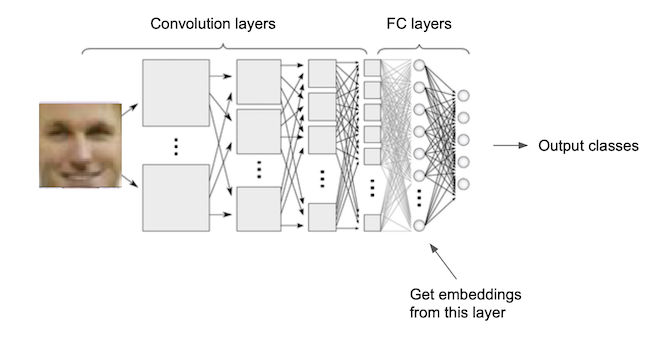

## Task 1 (30% points): build a neural network for faces classification as discribed above.

### Dataset 

We will train out face recognition network on part of the [CelebA dataset](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). We'll use a version of it that has all the images in it aligned. You can download the dataset using the links: 
- (whole celebA dataset) [dataset with 10177 classes](https://drive.google.com/file/d/1R-J71aJ50ahF-PkmaytLDyvbAiCccQdl/view?usp=sharing)
- [dataset with 1000 classes](https://drive.google.com/file/d/1JT9CMGjIbO7LtUuh8IYRc2OYrY0lGy5r/view?usp=sharing) 

**Important**: images in both datasets are aligned, but not cropped. To crop images, there're files with bboxes coordinates for each image in both datasets

Let's look at the data first:

- celebA_imgs — folder with aligned images 
- celebA_anno.txt — file with annotations: which person each image corresponds to
- celebA_train_split.txt — file with train/val/test info

In [1]:
import os
import cv2
import numpy as np
from PIL import Image
from skimage import io, transform

import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset

import matplotlib.pyplot as plt

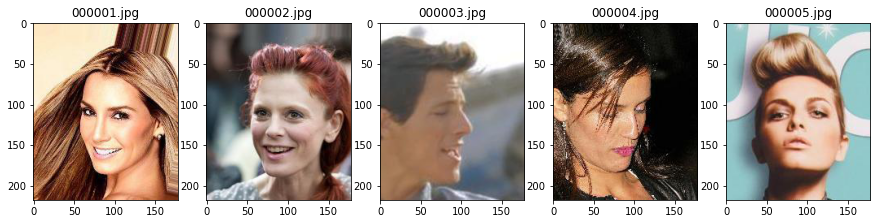

In [2]:
def show_imgs(images_names):
    imgs = []
    for img in images_names:
        img = Image.open(os.path.join('./datasets/celebA_train_1k/celebA_imgs/', img))
        imgs.append(np.array(img))

    f, axes= plt.subplots(1, len(imgs), figsize=(3*len(imgs),5))
    for i, axis in enumerate(axes):
        axes[i].imshow(imgs[i], cmap='gray')
        axes[i].set_title(images_names[i])
    plt.show()
    
    return imgs

images_names = os.listdir('datasets/celebA_train_1k/celebA_imgs/')[:5]
imgs = show_imgs(images_names)

### Train Neural Network

Let's build a Datasets and network using this images:

In [3]:
from tqdm import tqdm, trange
import torchvision.transforms.functional as TF

def get_paths(dataset_type='train'):
    '''
    a function that returnes list of imag"es paths for a given type of the dataset
    and list of corresponding labels
    params:
      dataset_type: one of 'train', 'val', 'test'
    '''

    labels_dict = {
        'train': 0,
        'val': 1,
        'test': 2,
    }

    f = open('datasets/celebA_train_1k/celebA_train_split.txt', 'r')
    lines = f.readlines()
    f.close()

    lines = [x.strip().split() for x in lines]
    lines = [x[0] for x in lines if int(x[1]) == labels_dict[dataset_type]]

    images_paths = []
    labels = []

    f = open('datasets/celebA_train_1k/celebA_anno_1k.txt', 'r')
    lines_anno = f.readlines()
    lines_anno = [x.strip().split() for x in lines_anno]
    f.close()

    lines_anno_iter = 0
    for filename in lines:            
        images_paths.append(os.path.join('datasets/celebA_train_1k/celebA_imgs/', filename))
        while(lines_anno[lines_anno_iter][0] != filename):
            lines_anno_iter += 1
        label = int(lines_anno[lines_anno_iter][1])
        labels.append(label)

    return np.array(images_paths), np.array(labels)

from torchvision.io import read_image


class celebADataset(Dataset):
    """Feel free to rewrite it. For ex. cache all images in RAM to increase training speed"""
    def __init__(self, dataset_type, transform, aug=None,):
        self.dataset_type = dataset_type
        self.transform = transform
        self.aug = aug
        self.paths, self.labels = get_paths(dataset_type)

    def __len__(self):
        return self.paths.shape[0]
    
    def __getitem__(self, idx): 
        x = TF.crop(self.transform(read_image(self.paths[idx])), 50, 40, 140, 100)
        y = self.labels[idx]
        if self.dataset_type == 'train':
            if self.aug is not None:
                x = aug(x)
        return x, y 

100%|████████████████████████████████████████████████████████████████████████| 17038/17038 [00:00<00:00, 415185.46it/s]


<BarContainer object of 1000 artists>

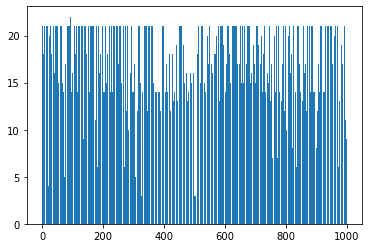

In [154]:
pics, labels = get_paths()
uniques, counts = np.unique(labels, return_counts=True)
plt.bar(uniques, counts)

In [4]:
import numpy as np
transform = transforms.Compose([
    transforms.Lambda(lambda image: torch.from_numpy(np.array(image).astype(np.float32)) / 256),
])

aug = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomGrayscale(0.1),
    transforms.ColorJitter(brightness=.5, hue=.3),
])

train_data = celebADataset('train', transform, aug)
val_data = celebADataset('val', transform, aug)
test_data = celebADataset('test', transform, aug)

# choose your own batch_size
batch_size = 256
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

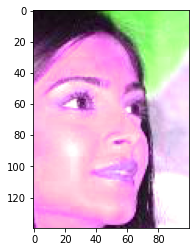

In [5]:
x, y = next(iter(train_loader))
plt.imshow(x[78].permute(1, 2, 0))

# Face alignment

In [25]:
import face_alignment
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, device='cpu', face_detector='sfd')

Downloading: "https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth" to C:\Users\user/.cache\torch\hub\checkpoints\s3fd-619a316812.pth


  0%|          | 0.00/85.7M [00:00<?, ?B/s]

In [45]:
preds = fa.get_landmarks_from_image((x[78]*256).permute(1, 2, 0))

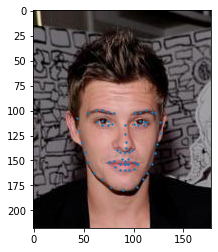

In [66]:
plt.imshow(x[78].permute(1, 2, 0))
for detection in preds:
    plt.scatter(detection[:,0], detection[:,1], 2)

In [49]:
import collections
pred_type = collections.namedtuple('prediction_type', ['slice', 'color'])
pred_types = {'face': pred_type(slice(0, 17), (0.682, 0.780, 0.909, 0.5)),
              'eyebrow1': pred_type(slice(17, 22), (1.0, 0.498, 0.055, 0.4)),
              'eyebrow2': pred_type(slice(22, 27), (1.0, 0.498, 0.055, 0.4)),
              'nose': pred_type(slice(27, 31), (0.345, 0.239, 0.443, 0.4)),
              'nostril': pred_type(slice(31, 36), (0.345, 0.239, 0.443, 0.4)),
              'eye1': pred_type(slice(36, 42), (0.596, 0.875, 0.541, 0.3)),
              'eye2': pred_type(slice(42, 48), (0.596, 0.875, 0.541, 0.3)),
              'lips': pred_type(slice(48, 60), (0.596, 0.875, 0.541, 0.3)),
              'teeth': pred_type(slice(60, 68), (0.596, 0.875, 0.541, 0.4))
              }


# Алайна, не будет - дс уже заалайнен

# Recognition model

In [12]:
# You may build your own model class or use some NN from library. 
# You may use NN pretrained on ImageNet
# model = # YOUR CODE HERE

In [6]:
import torch
import numpy as np
from skimage import io
import pickle

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn

import random

from matplotlib import colors, pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [7]:
from torchvision import models
model = models.resnet18(pretrained=True)

In [8]:
def print_grad_params(model):
    params_to_update = model.parameters()
    print("Params to learn:")
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)

In [9]:
for param in model.parameters():
    param.requires_grad = False
    
n_classes = 1000   
n_embedding = 1024
model.fc = nn.Sequential(
    nn.Linear(512, n_classes),
#     nn.ReLU(), 
#     nn.Linear(n_embedding, n_classes)
)

for param in model.layer4.parameters():
    param.requires_grad = True

for param in model.layer3.parameters():
    param.requires_grad = True
    
print_grad_params(model)

Params to learn:
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.bn2.weight
	 layer3.1.bn2.bias
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.0.weight
	 fc.0.bias


In [202]:
# Efficient net
# for param in model.parameters():
#     param.requires_grad = False
    
# n_classes = 1000
# model.classifier[1] = nn.Linear(1792, n_classes)

# for param in model.features[-1].parameters():
#     param.requires_grad = True
# for param in model.features[-2].parameters():
#     param.requires_grad = True

# params_to_update = model.parameters()
# print("Params to learn:")
# params_to_update = []
# for name,param in model.named_parameters():
#     if param.requires_grad == True:
#         params_to_update.append(param)
#         print("\t",name)

**Workflow**: fine-tune a model on train_data using val_data for validation.Use standard CE loss.  Calculate the loss and accuracy on test set after training. 

You may use any optimizer you want and any learning rate. It is also beneficial to freeze starting layers to boost training speed and avoid overfitting. 

Get as high score as possible!

In [191]:
# YOUR CODE HERE: train your model on train set and evaluate it on test set

In [10]:
DEVICE = torch.device('cuda')

In [11]:
def fit_epoch(model, train_loader, criterion, opt):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.type(torch.LongTensor).to(DEVICE)
        opt.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        opt.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
        if (i % 25 == 0):
            print(f'{i} / {len(train_loader)}')
    
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [12]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.type(torch.LongTensor).to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [13]:
from IPython.display import clear_output

def train(train_dataset, val_dataset, model, epochs):
    MODEL_NAME = type(model).__name__
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    best_val = 10000.
    best_epoch = 0
    best_val_score = 0
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=1e-3)
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-2, steps_per_epoch=1, epochs=epochs)
        
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            
            if val_loss < best_val:
                best_val = val_loss
                best_epoch = epoch
                best_val_score = val_acc
                torch.save(model.state_dict(), f'./models/{MODEL_NAME}_{epoch}')
            
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            clear_output(wait=True)
            print("loss", train_loss)
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            _loss, _acc, _val_loss, _val_acc = zip(*history)
            print(f'best epoch {best_epoch}, best_val_loss {best_val}, best_val_score {best_val_score}')
            plt.figure(figsize=(15, 9))
            plt.plot(_loss, label="train_loss")
            plt.plot(_val_loss, label="val_loss")
            plt.legend(loc='best')
            plt.xlabel("epochs")
            plt.ylabel("loss")
            plt.show()
            scheduler.step()
            
    return history

In [247]:
model = model.to(DEVICE)

epoch: 100%|███████████████████████████████████████████████████████████████████████████| 30/30 [32:27<00:00, 64.63s/it]

loss 0.0018678033639401266

Epoch 030 train_loss: 0.0019     val_loss 1.5394 train_acc 0.9999 val_acc 0.7385
best epoch 28, best_val_loss 1.5023556751153198, best_val_score 0.7470556745182013


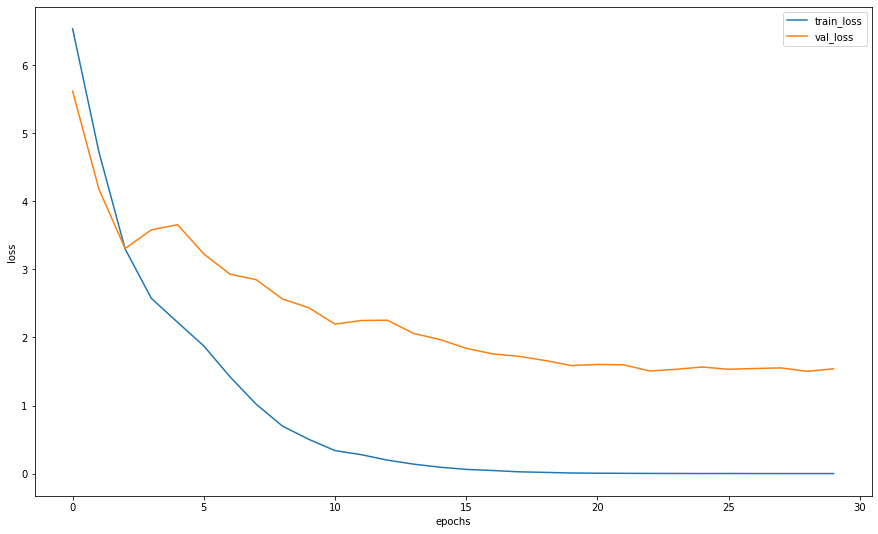

epoch: 100%|███████████████████████████████████████████████████████████████████████████| 30/30 [32:27<00:00, 64.91s/it]


In [209]:
torch.cuda.empty_cache()
history = train(train_loader, val_loader, model=model, epochs=30)

# Cosine similarity calculation

**Cosine similarity calculation**: drop a last layer of trained network. Get embeddings for some images from train set and for images from test set. Calculate cosine similarities between embeddings corresponding to the pictures of the same person and different people. Is the difference big in any of cases?

In [210]:
# YOUR CODE HERE
embedding_model = model
embedding_model.fc = nn.Identity()
cos = nn.CosineSimilarity(dim=1, eps=1e-6)

In [269]:
def get_embeddings(label):
    embeddings=[]
    
    xs = []
    train_data = celebADataset('train', transform, None)
    for x, y in iter(train_data):
        if y == label:
            xs.append(x)
    for x in xs:
        embeddings.append(embedding_model(x.unsqueeze(0).to(DEVICE)))
    
    test_embeddings=[]
    test_xs = []
    test_data = celebADataset('test', transform, None)
    for x, y in iter(test_data):
        if y == label:
            test_xs.append(x)
            
    for x in test_xs:
        test_embeddings.append(embedding_model(x.unsqueeze(0).to(DEVICE)))
        
    return embeddings, test_embeddings

In [270]:
e, t_e = get_embeddings(0) # of label 0

100%|██████████████████████████████████████████████████████████████████████████| 3174/3174 [00:00<00:00, 317113.00it/s]


In [282]:
def get_cosines(e, t_e):
    cosines = np.zeros((len(e) + len(t_e), len(e) + len(t_e)))

    for i, embedding1 in enumerate(e + t_e):
        for j, embedding2 in enumerate(e + t_e):
            cosines[i,j] = cos(embedding1, embedding2)
    plt.figure(figsize=(10,7))
    sns.heatmap(cosines)
    print(f' Min cos: {cosines.min()};\n Mean cos: {cosines.mean()}')
    return cosines

 Min cos: 0.42585107684135437;
 Mean cos: 0.6866194229125977


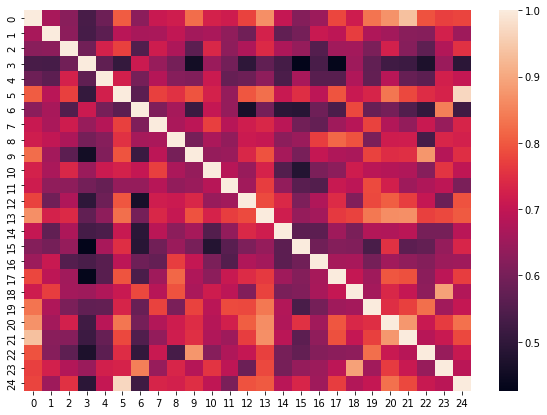

In [283]:
cosines_0 = get_cosines(e, t_e)

In [274]:
e_12, t_e_12 = get_embeddings(12)

100%|██████████████████████████████████████████████████████████████████████████| 3174/3174 [00:00<00:00, 317128.11it/s]


 Min cos: 0.4517158269882202;
 Mean cos: 0.7207578290705038


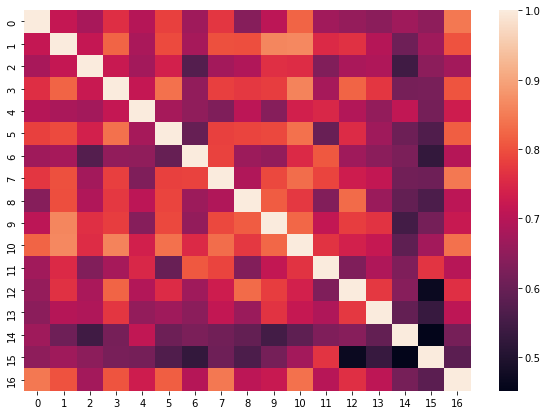

In [284]:
cosines_12 = get_cosines(e_12, t_e_12)

In [285]:
cosines_matrix = np.zeros((len(e + t_e), len(e_12 + t_e_12)))
for i, embedding1 in enumerate(e + t_e):
    for j, embedding2 in enumerate(e_12 + t_e_12):
        cosines_matrix[i,j] = cos(embedding1, embedding2)

<AxesSubplot:>

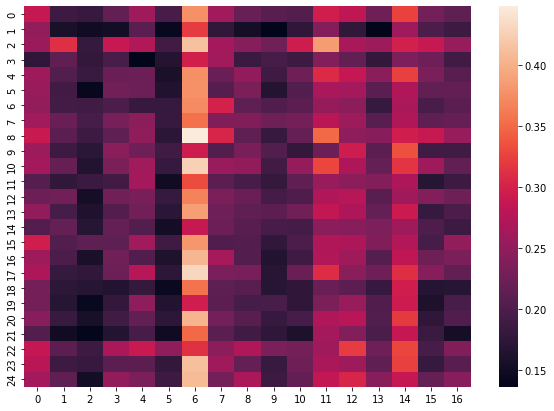

In [286]:
plt.figure(figsize=(10,7))
sns.heatmap(cosines_matrix)

In [290]:
print(f' Min cos:  {cosines_matrix.min()}\n Mean cos: {cosines_matrix.mean()}\n Max cos:  {cosines_matrix.max()}')

 Min cos:  0.13663145899772644
 Mean cos: 0.23066063919488122
 Max cos:  0.4484550952911377


### Cos similarity is lower for embeddings of different classes

**Cosine similarity distribution**: calculate all the cosine similarities between images in test dataset and train dataset of the same person. This means if you have image of person #106 in test dataset, calculate all similarities between this person's embeddings from test dataset and this person's embeddings from train dataset. 

Then also do that for pairs of different people. This means if you have image of person #106 in test dataset, calculate similarities between this person's embeddings from test dataset and other people embeddings from train dataset. 

This calculation may take a long time and memory since it's a lot of pairs. You can cut the number of pairs which you calculate distances between up to 5k, as an example.

### 1) **Cosine similarity distribution**: calculate all the cosine similarities between images in test dataset and train dataset of the same person. This means if you have image of person #106 in test dataset, calculate all similarities between this person's embeddings from test dataset and this person's embeddings from train dataset. 

In [301]:
def get_cosines(e, t_e):
    cosines = np.zeros((len(e), len(t_e)))
    for i, embedding1 in enumerate(e):
        for j, embedding2 in enumerate(t_e):
            cosines[i,j] = cos(embedding1, embedding2)
    return cosines

In [309]:
e, t_e = get_embeddings(106)
cosines_106 = get_cosines(e, t_e)

In [310]:
cosines_106.min(), cosines_106.mean(), cosines_106.max()

(0.3667796850204468, 0.6246306839443388, 0.8355611562728882)

<AxesSubplot:>

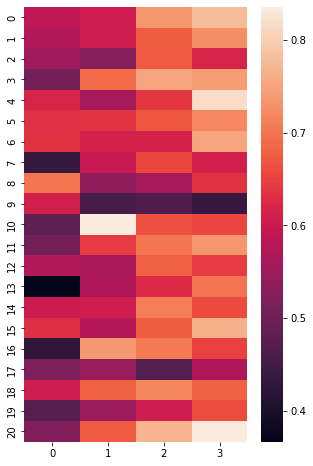

In [311]:
plt.figure(figsize=(5,8))
sns.heatmap(cosines_106)

### 2) Then also do that for pairs of different people. This means if you have image of person #106 in test dataset, calculate similarities between this person's embeddings from test dataset and other people embeddings from train dataset.

In [315]:
def pair_similarity(label_1, label_2):
    e1, t_e1 = get_embeddings(label_1)
    e2, t_e2 = get_embeddings(label_2)
    return get_cosines(t_e1, e2)

In [316]:
similarity_106_69 = pair_similarity(106, 69)

<AxesSubplot:>

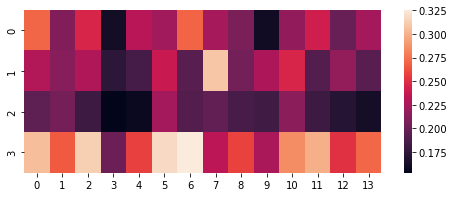

In [321]:
plt.figure(figsize=(8,3))
sns.heatmap(similarity_106_69)

In [318]:
similarity_106_69.min(), similarity_106_69.mean(), similarity_106_69.max()

(0.15281592309474945, 0.22356800282640116, 0.3256581127643585)

### Среднее similarity между первыми 20 классами

In [ ]:
labels = [i for i in range(20)]
embeddings = []
true_labels = []
for label in labels:
    e, t_e = get_embeddings(label)
    true_labels.append([label for i in range(len(e+t_e))])
    embeddings = embeddings + e + t_e

In [417]:
similarity_conf_matrix = np.zeros((20, 20))
shift = 0
for i, label1 in enumerate(labels):
    local_shift = 0
    for j, label2 in enumerate(labels):
        similarity_conf_matrix[i, j] = get_cosines(embeddings[shift:shift+len(true_labels[label1])],
                                                   embeddings[local_shift:local_shift+len(true_labels[label2])]).mean()
        local_shift += len(true_labels[label2])
    shift += len(true_labels[label1])

<AxesSubplot:>

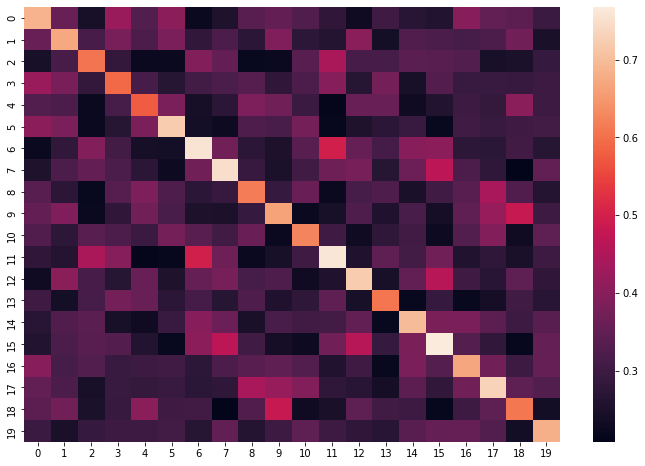

In [420]:
plt.figure(figsize=(12,8))
sns.heatmap(similarity_conf_matrix)

### TSNE визуализация

In [ ]:
X = []
for e in embeddings:
    X.append(e.squeeze(0).detach().cpu().numpy())

In [356]:
from sklearn.manifold import TSNE

y = TSNE(n_jobs=-1).fit_transform(np.array(X))

C:\ProgramData\Anaconda3\envs\torch_gpu\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\torch_gpu\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [363]:
np_labels=np.array([])
for l_array in true_labels:
    np_labels = np.concatenate((np_labels, np.array(l_array)))

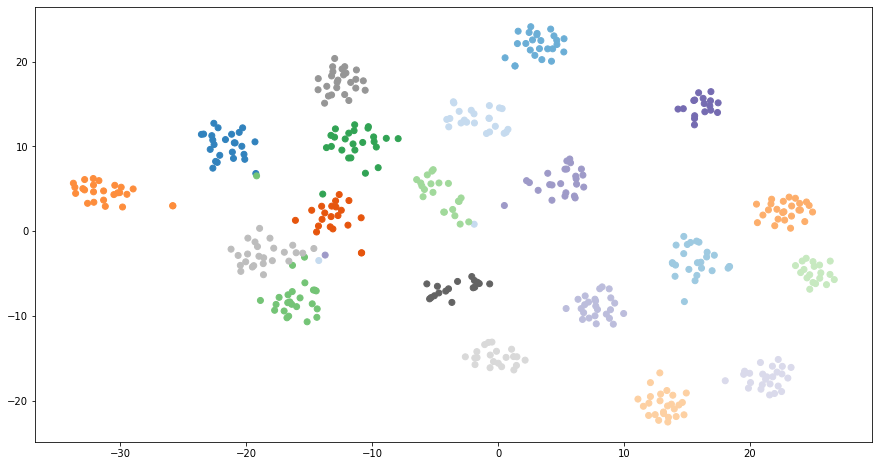

In [374]:
plt.figure(figsize=(15, 8))
plt.scatter(y[:, 0], y[:, 1], c=np_labels, cmap='tab20c')
plt.show()

## Task 2 (20% points): Identificaton rate metric

When training the model above we used CE loss on val and test set as a measure of performance of our model. But this has a major disadvantage: we can't measure how godd a model would work on unseen faces (which are not present in training, val & test sets)

To address this we can calculate another metric for the model: **identification rate**. This is how it works:

We have two sets of faces: query and distractors. None of the faces from those sets are present in train, val or test sets.

1. calculate cosine similarities between all the faces corresponding to the same people from query dataset. This means if the person has 3 photos in query part: 01.jpg, 02.jpg, 03.jpg, then calculate 3 cosine similarities between every pair of embeddings corresponding to those photos. 
2. calculate cosine similarities between all the faces corresponding to the different people from query dataset. 
3. calculate cosine similarities between all the pairs of embeddings corresponding to query and distractors. This means calculate similarities between pairs (q, d), where q is the embedding that corresponds to a face from query, d — embedding that corresponds to a face from distractors. You'll get |query|*|distractors| similarities.
4. Sum numbers of similarities from 2 and 3 stages. This is a number of false pairs.
5. fix **FPR** (false positive rate). Let it be 0.01 in our case. FPR multiplied by a number of false pairs from the stage 4 is the number of false positives we would allow our model to make. Let's call this number N
6. Sort all the similarities of false pairs by descending order. Get the Nth element from the beginning — that's our **threshold similarity**.
7. Calculate how many positive similarities from stage 1 are equal or more that threshold. Divide this number by whole number of positive similarities from stage 1. This is TPR (true positive rate) — our metric.

This metric can also be expressed as TPR@FPR=0.01. FPR can vary. 

Datasets (query photos, query labels & distructors photos) you can download from here: https://disk.yandex.ru/d/C54mClLmQkag6Q

**Task**: implement the TPR@FPR metric. Calculate it for your model and test dataset on FPR=[0.5, 0.2, 0.1, 0.05].

There're some functions pre-defined and some tests given for better understanding. Please don't change the functions prototypes, so that you can use asserts for checking.

In [452]:
from collections import defaultdict

# file with query part annotations: which image belongs to which class
# format: 
#     image_name_1.jpg 2678
#     image_name_2.jpg 2679
f = open('./datasets/celebA_ir/celebA_anno_query.txt', 'r')
query_lines = f.readlines()
f.close()
query_lines = [x.strip().split() for x in query_lines]
# plain list of image names from query. Neede to compute embeddings for query
query_img_names = [x[0] for x in query_lines]

# dictionary with info of which images from query belong to which class
# format:
#     {class: [image_1, image_2, ...]}
query_dict = defaultdict(list)
for img_name, img_class in query_lines:
    query_dict[img_class].append(img_name)

# list of distractor images
distractors_img_names = os.listdir('./datasets/celebA_ir/celebA_distractors') 

In [543]:
def compute_embeddings(model, images_list):
    '''
    compute embeddings from the trained model for list of images.
    params:
    model: trained nn model that takes images and outputs embeddings
    images_list: list of images paths to compute embeddings for
    output:
    list: list of model embeddings. Each embedding corresponds to images 
          names from images_list
    '''
    transform = transforms.Compose([
        transforms.Lambda(lambda image: torch.from_numpy(np.array(image).astype(np.float32)) / 256),
    ])
    outs = []
    for image in tqdm(images_list):
        if image in distractors_img_names:
            x = transform(read_image(f'./datasets/celebA_ir/celebA_distractors/{image}'))
        else:
            x = transform(read_image(f'./datasets/celebA_ir/celebA_query/{image}'))
            
        outs.append(model(x.unsqueeze(0).to(DEVICE)).detach().cpu().numpy())
    return outs

In [544]:
query_embeddings = compute_embeddings(embedding_model, query_img_names)
distractors_embeddings = compute_embeddings(model, distractors_img_names)

100%|████████████████████████████████████████████████████████████████████████████| 23397/23397 [06:42<00:00, 58.17it/s]


In [469]:
from sklearn.metrics.pairwise import cosine_similarity

In [739]:
def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):
    '''
    compute cosine similarities between positive pairs from query (stage 1)
    params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in 
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
    output:
    list of floats: similarities between embeddings corresponding 
                    to the same people from query list
    '''
    
    similarities = []
    for key in query_dict.keys():
        for i, name1 in enumerate(query_dict[key]):
            for j, name2 in enumerate(query_dict[key]):
                if i >= j:
                    continue
                e1 = np.array(query_embeddings[query_img_names.index(name1)])
                e2 = np.array(query_embeddings[query_img_names.index(name2)])
                if e1.shape[0] != 1:
                    e1 = np.array(query_embeddings[query_img_names.index(name1)]).reshape(1, -1)
                    e2 = np.array(query_embeddings[query_img_names.index(name2)]).reshape(1, -1)
                
                similarities.append(cosine_similarity(e1, e2).flatten().item())
    return similarities
    
def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
    '''
    compute cosine similarities between negative pairs from query (stage 2)
    params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in 
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
    output:
    list of floats: similarities between embeddings corresponding 
                    to different people from query list
    '''
    similarities = []
    embs = np.array(query_embeddings)
    similarities = []
    for i, key1 in enumerate(query_dict.keys()):
        for j, key2 in enumerate(query_dict.keys()):
            if i >= j:
                continue
            x = []
            y = []
            for name1 in query_dict[key1]:
                x.append(query_embeddings[query_img_names.index(name1)])
            for name2 in query_dict[key2]:
                y.append(query_embeddings[query_img_names.index(name2)])
            b_x = len(x)
            b_y = len(y)
            x = np.array(x)
            y = np.array(y)
            if x.shape[1] == 1:
                x = np.array(x).squeeze(1)
                y = np.array(y).squeeze(1)
            m = list(cosine_similarity(x, y).flatten())
            similarities += m                
    return similarities

def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
    '''
    compute cosine similarities between negative pairs from query and distractors
    (stage 3)
    params:
    query_embeddings: list of embeddings corresponding to query_img_names
    distractors_embeddings: list of embeddings corresponding to distractors_img_names
    output:
    list of floats: similarities between pairs of people (q, d), where q is 
                    embedding corresponding to photo from query, d —
                    embedding corresponding to photo from distractors
    '''
    x = np.array(query_embeddings)
    y = np.array(distractors_embeddings)
    if x.shape[1] == 1:
        x = np.array(x).squeeze(1)
        y = np.array(y).squeeze(1)
    return list(cosine_similarity(x, y).flatten())
#     return similarities

In [ ]:
cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names, 
                                            query_embeddings)
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names, 
                                            query_embeddings)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings, 
                                                            distractors_embeddings)

Check you code of functions which compute similarities:

In [743]:
test_query_dict = {
    2876: ['1.jpg', '2.jpg', '3.jpg'],
    5674: ['5.jpg'],
    864:  ['9.jpg', '10.jpg'],
}
test_query_img_names = ['1.jpg', '2.jpg', '3.jpg', '5.jpg', '9.jpg', '10.jpg']
test_query_embeddings = [
                    [1.56, 6.45,  -7.68],
                    [-1.1 , 6.11,  -3.0],
                    [-0.06,-0.98,-1.29],
                    [8.56, 1.45,  1.11],
                    [0.7,  1.1,   -7.56],
                    [0.05, 0.9,   -2.56],
]

test_distractors_img_names = ['11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg']

test_distractors_embeddings = [
                    [0.12, -3.23, -5.55],
                    [-1,   -0.01, 1.22],
                    [0.06, -0.23, 1.34],
                    [-6.6, 1.45,  -1.45],
                    [0.89,  1.98, 1.45],
]

test_cosine_query_pos = compute_cosine_query_pos(test_query_dict, test_query_img_names, 
                                            test_query_embeddings)
test_cosine_query_neg = compute_cosine_query_neg(test_query_dict, test_query_img_names, 
                                            test_query_embeddings)
test_cosine_query_distractors = compute_cosine_query_distractors(test_query_embeddings, 
                                                            test_distractors_embeddings)

In [744]:
true_cosine_query_pos = [0.8678237233650096, 0.21226104378511604,
                         -0.18355866977496182, 0.9787437979250561]
assert np.allclose(sorted(test_cosine_query_pos), sorted(true_cosine_query_pos)), "A mistake in compute_cosine_query_pos function"

true_cosine_query_neg = [0.15963231223161822, 0.8507997093616965, 0.9272761484302097,
                         -0.0643994061127092, 0.5412660901220571, 0.701307100338029,
                         -0.2372575528216902, 0.6941032794522218, 0.549425446066643,
                         -0.011982733001947084, -0.0466679194884999]
assert np.allclose(sorted(test_cosine_query_neg), sorted(true_cosine_query_neg)), "A mistake in compute_cosine_query_neg function"

true_cosine_query_distractors = [0.3371426578637511, -0.6866465610863652, -0.8456563512871669,
                                 0.14530087113136106, 0.11410510307646118, -0.07265097629002357,
                                 -0.24097699660707042,-0.5851992679925766, 0.4295494455718534,
                                 0.37604478596058194, 0.9909483738948858, -0.5881093317868022,
                                 -0.6829712976642919, 0.07546364489032083, -0.9130970963915521,
                                 -0.17463101988684684, -0.5229363015558941, 0.1399896725311533,
                                 -0.9258034013399499, 0.5295114163723346, 0.7811585442749943,
                                 -0.8208760031249596, -0.9905139680301821, 0.14969764653247228,
                                 -0.40749654525418444, 0.648660814944824, -0.7432584300096284,
                                 -0.9839696492435877, 0.2498741082804709, -0.2661183373780491]
assert np.allclose(sorted(test_cosine_query_distractors), sorted(true_cosine_query_distractors)), "A mistake in compute_cosine_query_distractors function"

Implement the final function: identification rate calculation

In [750]:
def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, 
               fpr=0.1):
    '''
    compute identification rate using precomputer cosine similarities between pairs
    at given fpr
    params:
    cosine_query_pos: cosine similarities between positive pairs from query
    cosine_query_neg: cosine similarities between negative pairs from query
    cosine_query_distractors: cosine similarities between negative pairs 
                              from query and distractors
    fpr: false positive rate at which to compute TPR
    output: 
    float: threshold for given fpr 
    float: TPR at given FPR
    '''
    N = min(int(fpr * (len(cosine_query_neg) + len(cosine_query_distractors))), 
            len(cosine_query_neg + cosine_query_distractors))
    treshold = sorted(cosine_query_neg + cosine_query_distractors, reverse=True)[N]
    print('sorted!')
    good_pos_pairs = 0
    for pos_pair in cosine_query_pos:
        if pos_pair > treshold:
            good_pos_pairs += 1
    TPR = good_pos_pairs / len(cosine_query_pos)
    return treshold, TPR

Check yourself:

In [751]:
test_thr = []
test_tpr = []
for fpr in [0.5, 0.3, 0.1]:
    x, y = compute_ir(test_cosine_query_pos, test_cosine_query_neg, 
                    test_cosine_query_distractors, fpr=fpr)
    test_thr.append(x)
    test_tpr.append(y)

sorted!
sorted!
sorted!


In [752]:
true_thr = [-0.011982733001947084, 0.3371426578637511, 0.701307100338029]
assert np.allclose(np.array(test_thr), np.array(true_thr)), "A mistake in computing threshold"

true_tpr = [0.75, 0.5, 0.5]
assert np.allclose(np.array(test_tpr), np.array(true_tpr)), "A mistake in computing tpr"

Finally compute tpr for faces query and distractors dataset and fpr = [0.5, 0.2, 0.1, 0.05]:

In [753]:
thr = []
tpr = []
for fpr in [0.5, 0.2, 0.1, 0.05]:
    x, y = compute_ir(cosine_query_pos, cosine_query_neg, 
                      cosine_query_distractors, fpr=fpr)
    thr.append(x)
    tpr.append(y)
    print(f'{fpr} done!')

sorted!
0.5 done!
sorted!
0.2 done!
sorted!
0.1 done!
sorted!
0.05 done!


In [762]:
thr

[0.55739427, 0.65087897, 0.6977197, 0.73418725]

In [764]:
tpr

[0.8270752765536469,
 0.5782669304793596,
 0.42693812393200825,
 0.31099919057469194]

## Task 3 (50% points): Loss functions

Building a network on task 1 we used an ordinary CE loss. But there are many more variants of loss functions that can be used to train neural network. We will discuss two of them, which are the most popular. More examples of losses for face recognition and their performance reviews you can find in this paper: https://arxiv.org/pdf/1901.05903.pdf

### TripletLoss (25% points)

This is another kind of loss which does not require a model to have last classification layer — it works directly with embeddings. It requires by design to make embeddings of one person be close on embeddings space and embeddings of different people be far away from each other. 

This loss has an advantage over CE-like losses: it does not rely on number of classes in dataset. If we have new faces of new people in a dataset, we won't need to completely retrain the network, we could just fine-tune the trained network on new photos.


**How TripletLoss works**:

Here the architecture of neural network will be slightly different than it was when we used CE loss: it won't have the last classification layer. The last layer of NN will output embeddings of the given photo. 

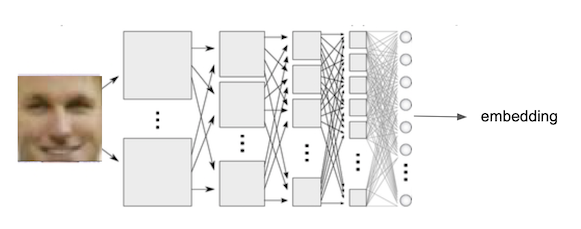

The TripletLoss function works directly with these embeddings. The idea of it is to make embeddings of the same people more close, compact in the embedding space, and the embeddings of the different people be more separate. There's a formula for the loss:

$$L(e, p, n) = max\{d(a, p) - d(a, n) + margin, 0\},$$

where 
- $e$ is embedding of a photo (output of a model)
- $p$ is a positive embedding for the photo (embedding that we want $e$ be close to)
- $n$ is a negative embedding for the photo (embedding that we want $e$ be far from)
- $d(x, y)$ is a distance measure between embeddings 
- margin — a positive margin to further boost the difference between $d(a, p)$ and $d(a, n)$

**All the embeddings $e$, $p$ and $n$ must be normalized before passing them to the loss**.

In our case for the given photo $E$ and it's embedding $e$ positive embedding $p$ must be an embedding of the photo of the same person and embedding $n$ must be an ambedding of the photo of the different person.

This emplementation of TripletLoss for PyTorch can be found [here](https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss). There are different variants of TripletLoss which can also boost performance and which you can implement by yourself, if you want:
- use more that 1 sample of $p$ and $n$ for one embedding $e$ 
- use special kinds of negatives: e.g. the negatives that are the most close to e (to boost them be further away from e)


**More to read about TripletLoss**:

The idea of TripletLoss: https://en.wikipedia.org/wiki/Triplet_loss

PyTorch implementation of TripletLoss: https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss

**Task**: implement a model and train it with TripletLoss. Play with margin parameter to achieve better results.

Which loss among which you have tried is the best?

As we don't have a classification layer in our network, we need a custom procedure for accuracy calculation. You can use one of the following procedures:
- calculate accuracy on val and test sets using KNN with embeddings from training set as training points. (easy way)
- compute mean embeddings for every class from training set and use them as reference embeddings. Then for every embedding v from val and test sets calculate cosine similarities between v and mean embeddings from train set. (the more "right" way, but requires code writing)

You can use any of those two variants.

**Hints**:
- think of what the distance function $d$ should be in our case: training a model we want it to output embeddings which can be compared using cosine similarity function. Pay attention to that cosine similarity is not a distance measure — the more cosine distance, the closer embeddings are. Think how you can put cosine distance into TripletLoss function.
- to train model using this loss you'll need to rewrite the Dataset class so it gives you not the random image and its label, but the image, positive images and negative images for this image;
- don't forget to normalize embeddings for the loss! You may even do that by adding batchnorm/layernorm to the last layer of your network

In [230]:
import random

def fast_rand_choice(elems, p):
    """Choose a random element weighted by p.

    Faster than np.random.choice, assumes that sum of p is one.

    Thanks to: https://twitter.com/radimrehurek/status/928671225861296128

    """
    return elems[np.searchsorted(np.cumsum(p), np.random.random())]

class celebADataset(Dataset):
    """Feel free to rewrite it. For ex. cache all images in RAM to increase training speed"""
    def __init__(self, dataset_type, transform, aug=None,):
        self.dataset_type = dataset_type
        self.transform = transform
        self.aug = aug
        self.paths, self.labels = get_paths(dataset_type)
        self.label_to_paths = {}
        self.mode = 'triplets'
        self._indices = np.arange(len(self.paths))
        
        for p, l in zip(self.paths, self.labels):
            if l not in self.label_to_paths:
                self.label_to_paths.update({l : [p]})
            else:
                self.label_to_paths[l].append(p)
    @staticmethod
    def get_sample_weight_pos(y, i):
        sample_weight = y == y[i]
        sample_weight[i] = 0
        sample_weight = sample_weight / sample_weight.sum()
        return sample_weight

    @staticmethod
    def get_sample_weight_neg(y, i):
        sample_weight = y != y[i]
        sample_weight = sample_weight / sample_weight.sum()
        return sample_weight
                
    def __len__(self):
        return self.paths.shape[0]
    
    def __getitem__(self, idx): 
        x = TF.crop(self.transform(read_image(self.paths[idx])), 50, 40, 140, 100) # anchor
        y = self.labels[idx]
        
        if self.dataset_type == 'train' and self.mode == 'triplets':
            p_pos = get_sample_weight_pos(self.labels, idx)
            j = fast_rand_choice(self._indices, p=p_pos)
            positive_image = TF.crop(self.transform(read_image(self.paths[j])), 50, 40, 140, 100)
            
            p_neg = get_sample_weight_neg(self.labels, idx)
            k = fast_rand_choice(self._indices, p=p_neg)
            negative_image = TF.crop(self.transform(read_image(self.paths[k])), 50, 40, 140, 100)

            if self.aug is not None:
                x = aug(x)
                positive_image = aug(positive_image)
                negative_image = aug(negative_image)

            xs = x, positive_image, negative_image 
            return xs, y 
        else:
            return x, y
    
    def set_triplet_mode(self):
        self.mode = 'triplets'
    def set_anchor_mode(self):
        self.mode = 'anchor_only'


In [231]:
import numpy as np
transform = transforms.Compose([
    transforms.Lambda(lambda image: torch.from_numpy(np.array(image).astype(np.float32)) / 256),
])

aug = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomGrayscale(0.1),
    transforms.ColorJitter(brightness=.5, hue=.3),
])

train_data = celebADataset('train', transform, aug)
val_data = celebADataset('val', transform, aug)
test_data = celebADataset('test', transform, aug)


batch_size = 256
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

CPU times: total: 14.6 s
Wall time: 1.82 s


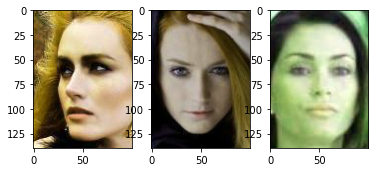

In [232]:
%%time
x, y = next(iter(train_loader))
plt.subplot(1, 3, 1)
plt.imshow(x[0][78].permute(1, 2, 0))
plt.subplot(1, 3, 2)
plt.imshow(x[1][78].permute(1, 2, 0))
plt.subplot(1, 3, 3)
plt.imshow(x[2][78].permute(1, 2, 0))

In [233]:
from torchvision import models
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    
n_classes = 1000   
n_embedding = 1024
model.fc = nn.Sequential(
    nn.Linear(512, n_embedding),
    nn.BatchNorm1d(n_embedding),
)

for param in model.layer4.parameters():
    param.requires_grad = True

for param in model.layer3.parameters():
    param.requires_grad = True

In [186]:
def predict(model, x, ref_embs):
    out = model(x.to(DEVICE)).detach().cpu()
    scores = F.normalize(out) @ F.normalize(ref_embs).t()
    preds = np.argmax(scores, axis=1)
    return preds

def predict_train(model, out, ref_embs):
    #   out = [tensor, tensor, ...]
#     print(out)
    x = torch.zeros((len(out), 1024))  
    torch.stack(out, dim=0, out=x)
    scores = F.normalize(x) @ F.normalize(ref_embs).t()
    preds = np.argmax(scores, axis=1)
    return list(preds)

def fit_epoch(model, train_loader, criterion, opt):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    train_loss = 0
    train_embeddings = {i: [] for i in range(1000)}
    
    for i, (inputs, labels) in enumerate(train_loader):
        anchor, positive, negative = inputs
        anchor, positive, negative = anchor.to(DEVICE), positive.to(DEVICE), negative.to(DEVICE)
        opt.zero_grad()
    
        anchor_out = model(anchor)
        positive_out = model(positive)
        negative_out = model(negative)

            
        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        opt.step()
        
                
        # SAVE ANCHORS TO REFERENCE EMBEDDINGS!
        for o, l in zip(anchor_out.detach().cpu(), labels):
            train_embeddings[l.item()].append(o)
        
        running_loss += loss.item() * anchor.size(0)
        processed_data += anchor.size(0)
        if (i % 5 == 0):
            print(f'{i} / {len(train_loader)}')
            
            
    model.eval()
    reference_embeddings = {i : 0 for i in range(1000)}
    for key in train_embeddings.keys():
        s = torch.zeros((1024))
        for el in train_embeddings[key]:
            s += el
        reference_embeddings[key] = s / len(train_embeddings[key])
    ref_embs = torch.zeros((1000, 1024))  
    torch.stack(list(reference_embeddings.values()), dim=0, out=ref_embs)
    
    true_train = []
    pred_train = []
    for key in train_embeddings.keys():
        pred_train += predict_train(model, train_embeddings[key], ref_embs)
        true_train += [key for i in range(len(train_embeddings[key]))]
    
    train_loss = running_loss / processed_data
    return train_loss, accuracy_score(true_train, pred_train), ref_embs

In [187]:
from sklearn.metrics import accuracy_score

                      
def eval_epoch(model, train_loader, val_data, ref_embs):
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
    model.eval()
        
    true_val = []
    pred_val = []
    
    for x, y in tqdm(iter(val_loader)):
        preds = predict(model, x, ref_embs)
        pred_val += list(preds.numpy())   
        true_val += list(y.numpy())
        
    return accuracy_score(true_val, pred_val) 

In [188]:
from IPython.display import clear_output
import torch.nn.functional as F
def train(train_loader, val_dataset, model, epochs):
    MODEL_NAME = type(model).__name__
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
     train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    best_val = 10000.
    best_epoch = 0
    best_val_score = 0
    val_acc = 0
    
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=1e-2)
        criterion = nn.TripletMarginWithDistanceLoss(distance_function=lambda x, y: 1.0 - F.cosine_similarity(x, y))
        scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-2, steps_per_epoch=1, epochs=epochs)
        
        for epoch in range(epochs):
            train_loss, train_acc, ref_embs = fit_epoch(model, train_loader, criterion, opt)
            val_acc = eval_epoch(model, train_loader, val_dataset, ref_embs)
                
            if best_val_score < val_acc:
                best_epoch = epoch
                best_val_score = val_acc
                torch.save(model.state_dict(), f'./models/triplet_{MODEL_NAME}_{epoch}')
            
            history.append((train_loss, train_acc, val_acc))
            
            clear_output(wait=True)
            print("loss", train_loss)
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           t_acc=train_acc, v_acc=val_acc))
            
            _loss, _acc, _val_acc = zip(*history)
            print(f'best epoch {best_epoch}, best_val_loss {best_val}, best_val_score {best_val_score}')
            plt.figure(figsize=(8, 5))
            plt.grid(True)
            plt.plot(_loss, label="train_loss")
            plt.legend(loc='best')
            plt.xlabel("epochs")
            plt.ylabel("loss")
            plt.show()
            scheduler.step()
            
    return history, ref_embs

In [189]:
DEVICE = torch.device('cuda')

epoch: 100%|████████████████████████████████████████████████████████████████████████| 30/30 [1:19:44<00:00, 158.90s/it]

loss 0.21501359849563015

Epoch 030 train_loss: 0.2150      train_acc 0.0843 val_acc 0.0629
best epoch 29, best_val_loss 10000.0, best_val_score 0.06290149892933619


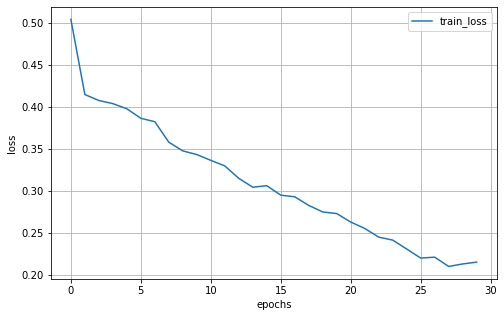

epoch: 100%|████████████████████████████████████████████████████████████████████████| 30/30 [1:19:44<00:00, 159.48s/it]


In [190]:
torch.cuda.empty_cache()
model = model.to(DEVICE)
history, ref_embs = train(train_loader, val_data, model=model, epochs=30)

In [219]:
model.eval()

embeddings = [] 
labels_for_embs = []
for inputs, labels in tqdm(iter(train_data)):
    if labels > 15:
        continue
    anchor, _, _ = inputs
    anchor = anchor.to(DEVICE)

    anchor_out = model(anchor.unsqueeze(0))
    labels_for_embs.append(labels.item())
    embeddings.append(out.detach().cpu())
    

17038it [01:54, 149.39it/s]


In [220]:
np.unique(labels_for_embs)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [221]:
embeddings_tensor = torch.zeros((len(labels_for_embs), 1024))  
torch.stack(embeddings, dim=0, out=embeddings_tensor)
print(embeddings_tensor.shape)

torch.Size([318, 1024])


In [222]:
from sklearn.manifold import TSNE
X = embeddings_tensor
y = TSNE(n_jobs=-1).fit_transform(np.array(X))

C:\ProgramData\Anaconda3\envs\torch_gpu\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\torch_gpu\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


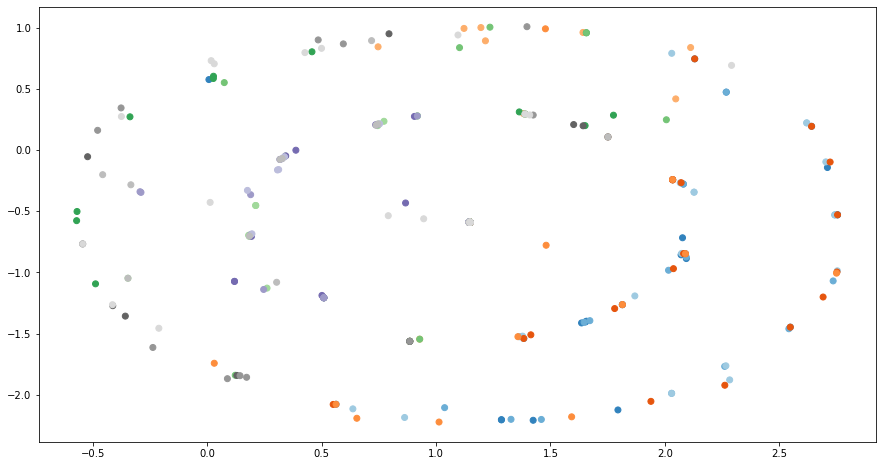

In [223]:
plt.figure(figsize=(15, 8))
plt.scatter(y[:, 0], y[:, 1], c=labels_for_embs, cmap='tab20c')
plt.show()

## Видно, что раскидались, но бесопрядочно. Оч долго работает, предлагаю объединить CE и triplet-loss


In [228]:
model.load_state_dict(torch.load('models/ResNet_28'))

<All keys matched successfully>

In [229]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### ArcFace Loss (Additive Angular Margin Loss) (25% points)

This loss is somewhat "SOTA" for face recognition systems (somewhat — because actually different variants of losses and their combinations may be the best for different network architectures). This loss inherits idea from CE loss but further develops it to achieve better embeddings distribution on a sphere. It introduces some geodesic constraints to enhance intra-class compactness and inter-class discrepancy.



**How ArcFace loss works**:

This loss is a variation of a standard SoftMax CE loss, which enforces embeddings of different classes (people) be further away: have a more sparse representation of embeddings in embedding space, enforce more evident gap between the nearest classes.

The standard SoftMax CE loss for classification task is presented as follows:

$$L_{CE} = \frac{-1}{N}\sum_1^N \frac{e^{W_{y_i}^{T}x_i + b_{y_i}}}{\sum^n_{j=1}e^{W_j^Tx_i+b_j}},$$

where:
- $x_i \in \mathbb{R^d}$ denotes the deep feature of the $i$-th sample, belonging to the $y_i$-th class;
- $W_j \in \mathbb{R^d}$ denotes the j-th column of the weight;
- $W \in \mathbb{R^d}$ and $b_j \in \mathbb{R^d}$ is the bias term;
- $N$ — batch size;
- $n$ — class number.

It appears, that, though this loss works well, it does not explicitly optimise the feature embedding to enforce higher similarity for intra- class samples and diversity for inter-class samples, which results in a performance gap for deep face recognition under large intra-class appearance variations.

Let's do some work on this loss formula:
- fix the bias $b_j=0$;
- normalize weight ||$W_j$|| = 1;
- normalize embedding ||$x_i$|| = 1 and re-scale it to s (s is a hyperparameter)

The normalisation step on embeddings and weights makes the predictions only depend on the angle between the embedding and the weight. The learned embeddings fare thus distributed on a hypersphere with a radius of s.

So we get the following loss function now:

$$L = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos\Theta_{y_i}}}{e^{s\ cos\Theta_{y_i}} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

Final step: let's add an additive angular margin penalty $m$ between $x_i$ and $W_{y_i}$ to simultaneously enhance the intra-class compactness and inter-class discrepancy:

$$L_{ArcFace} = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos(\Theta_{y_i} + m)}}{e^{s\ cos(\Theta_{y_i} + m)} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

SO this is an ArcFace loss. It has 2 hyperparameters: s and m.

The original paper to read about ArcFace more precisely: https://arxiv.org/pdf/1801.07698.pdf

The original repo, where you can find a code sample: https://github.com/deepinsight/insightface

**Task**: implement a model and train it with ArcFace loss. Play with ArcFace loss parameters and see if you can beat a model with CE loss.

In [14]:
DEVICE = 'cuda'

In [40]:
def fit_epoch(model, train_loader, criterion, opt):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.type(torch.LongTensor).to(DEVICE)
        opt.zero_grad()

        outputs = model(inputs, labels)
        loss = criterion(outputs, labels)
        loss.backward()
        opt.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
        if (i % 25 == 0):
            print(f'{i} / {len(train_loader)}')
    
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [52]:
# https://www.kaggle.com/code/zaccheroni/pytorch-efficientnet-arcface-training/notebook
import math
import torch.nn.functional as F

class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.20, easy_margin=False):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, train, label=False):
        cosine = F.normalize(input) @ F.normalize(self.weight).t()
        sine = torch.sqrt((1.0 - torch.pow(cosine, 2)).clamp(0, 1))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        if train:

            one_hot = torch.zeros(cosine.size(), device=DEVICE)
            if DEVICE == 'cuda':
                one_hot.scatter_(1, label.cuda().view(-1, 1).long(), 1)
            else:
                one_hot.scatter_(1, label.view(-1, 1).long(), 1)
                
            output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        else:
            output = cosine
        output *= self.s

        return output

In [ ]:
from torchvision import models

class ArcNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(ArcNet, self).__init__()
        # ResNet base
        self.base = models.resnet18(pretrained=True)
        
        for param in self.base.parameters():
            param.requires_grad = False
        self.base.fc = nn.Identity()      
        for param in self.base.layer4.parameters():
            param.requires_grad = True

        for param in self.base.layer3.parameters():
            param.requires_grad = True
            
        self.base = self.base.to(DEVICE)
        
        # Arcface
        self.arcface = ArcMarginProduct(512, num_classes).to(DEVICE)   
        
    def forward(self, x, label):
        x = self.base(x)
        if self.training:
            x = self.arcface(x, self.training, label)
        else:
            x = self.arcface(x, self.training)
        return x

In [53]:
from IPython.display import clear_output

def train(train_dataset, val_dataset, model, epochs):
    MODEL_NAME = type(model).__name__
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    best_val = 10000.
    best_epoch = 0
    best_val_score = 0
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
        criterion = nn.CrossEntropyLoss()
#         scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-2, steps_per_epoch=1, epochs=epochs)
        
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            
            if val_loss < best_val:
                best_val = val_loss
                best_epoch = epoch
                best_val_score = val_acc
                torch.save(model.state_dict(), f'./models/arc_30_20_{MODEL_NAME}_{epoch}')
            
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            clear_output(wait=True)
            print("loss", train_loss)
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            _loss, _acc, _val_loss, _val_acc = zip(*history)
            print(f'best epoch {best_epoch}, best_val_loss {best_val}, best_val_score {best_val_score}')
            plt.figure(figsize=(15, 9))
            plt.plot(_loss, label="train_loss")
            plt.plot(_val_loss, label="val_loss")
            plt.legend(loc='best')
            plt.xlabel("epochs")
            plt.ylabel("loss")
            plt.show()
#             scheduler.step()
            
    return history

epoch: 100%|███████████████████████████████████████████████████████████████████████████| 60/60 [49:51<00:00, 49.80s/it]

loss 0.01757313870002874

Epoch 060 train_loss: 0.0176     val_loss 1.3770 train_acc 0.9997 val_acc 0.7230
best epoch 49, best_val_loss 1.3671494091858956, best_val_score 0.7240364025695932


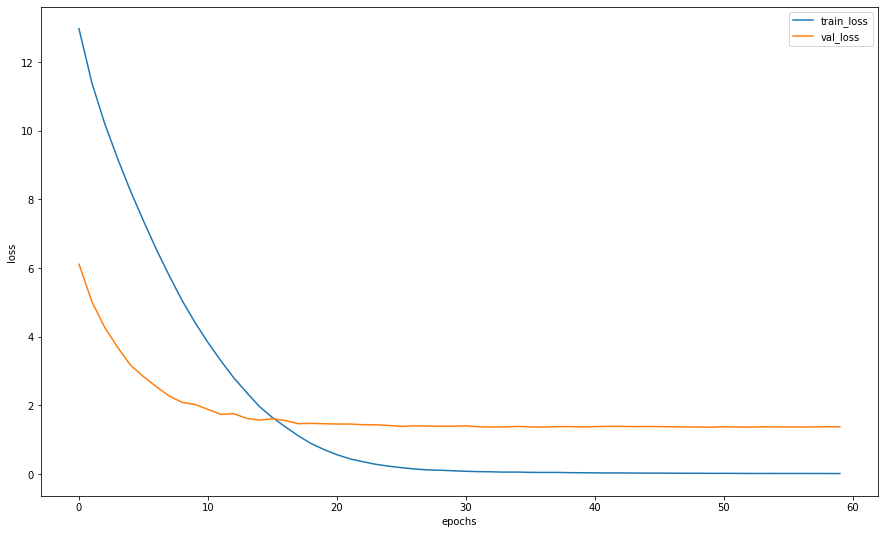

epoch: 100%|███████████████████████████████████████████████████████████████████████████| 60/60 [49:51<00:00, 49.86s/it]


In [54]:
model = ArcNet(1000)

history = train(train_loader, val_loader, model=model, epochs=60)

In [58]:
# https://www.kaggle.com/code/zaccheroni/pytorch-efficientnet-arcface-training/notebook
import math
import torch.nn.functional as F

class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.10, easy_margin=False):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, train, label=False):
        cosine = F.normalize(input) @ F.normalize(self.weight).t()
        sine = torch.sqrt((1.0 - torch.pow(cosine, 2)).clamp(0, 1))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        if train:

            one_hot = torch.zeros(cosine.size(), device=DEVICE)
            if DEVICE == 'cuda':
                one_hot.scatter_(1, label.cuda().view(-1, 1).long(), 1)
            else:
                one_hot.scatter_(1, label.view(-1, 1).long(), 1)
                
            output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        else:
            output = cosine
        output *= self.s

        return output

In [59]:
from IPython.display import clear_output

def train(train_dataset, val_dataset, model, epochs):
    MODEL_NAME = type(model).__name__
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    best_val = 10000.
    best_epoch = 0
    best_val_score = 0
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
        criterion = nn.CrossEntropyLoss()
#         scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-2, steps_per_epoch=1, epochs=epochs)
        
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            
            if val_loss < best_val:
                best_val = val_loss
                best_epoch = epoch
                best_val_score = val_acc
                torch.save(model.state_dict(), f'./models/arc_30_10_{MODEL_NAME}_{epoch}')
            
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            clear_output(wait=True)
            print("loss", train_loss)
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            _loss, _acc, _val_loss, _val_acc = zip(*history)
            print(f'best epoch {best_epoch}, best_val_loss {best_val}, best_val_score {best_val_score}')
            plt.figure(figsize=(15, 9))
            plt.plot(_loss, label="train_loss")
            plt.plot(_val_loss, label="val_loss")
            plt.legend(loc='best')
            plt.xlabel("epochs")
            plt.ylabel("loss")
            plt.show()
#             scheduler.step()
            
    return history

epoch:   2%|█▎                                                                          | 1/60 [00:51<50:36, 51.46s/it]

loss 9.95532510873647

Epoch 001 train_loss: 9.9553     val_loss 6.1108 train_acc 0.0000 val_acc 0.0286
best epoch 0, best_val_loss 6.110806501907251, best_val_score 0.028640256959314776


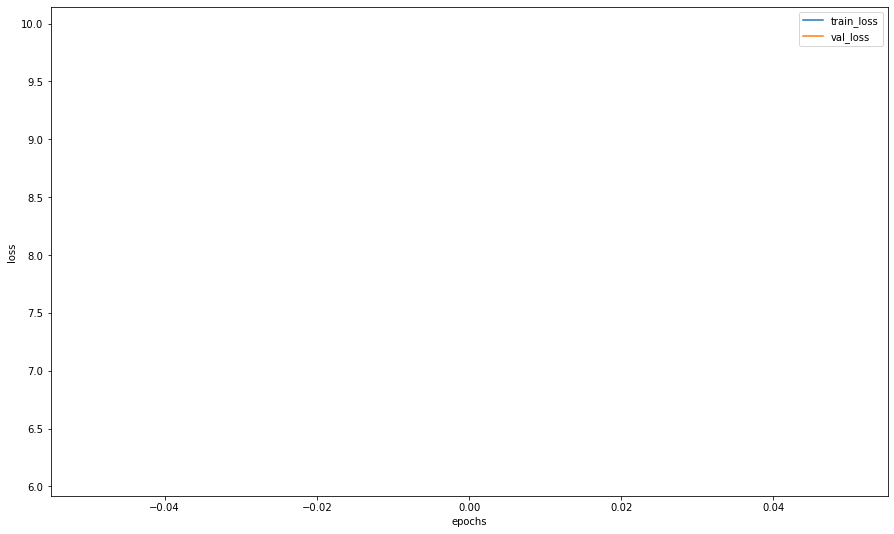

0 / 67
25 / 67


In [ ]:
model = ArcNet(1000)

history = train(train_loader, val_loader, model=model, epochs=60)

## Bonus task (5% points): Finding trash photos 

You have probably noticed that in identification rate calculation we use cosine similarity between embeddings, which includes embeddings' normalization. And in TripletLoss also we normalize embeddings before passing them to the loss. Actually this is how most of the face recognition algorithms work — they are designed to output a normalized embeddings and any comparison between embeddings is done after the embeddings are normalized. Sometimes it may be beneficial even to add a normalization layer (batchnorm or layernorm with fixed parameters) after the model's embedding layer to make the model output normalized embeddings.

But norms of the unnormalized embeddings can also be used. They can be used to detect trash photos — photos, where the face is presented really badly (e.g. back of the head instead of the forehead or even a photo without any head that has appeared in a dataset due to a mistake in face detection / landmarks detection algorithm).

Empirically it has been found that the higher the embedding's norm, the more the probability of the corresponding photo to be trash is. 



**Task**: get the embeddings of photos in a test set / query set / distractors set. Sort them by their norms. Output the photos whose embeddings norms are the highest. Do they look like normal or trash?

**Doing this task will not give you points above 100% for the whole homework. But if you have any mistakes in previous sections, doing this task may give you additional points (5% of total points) to cover points lost.**

In [ ]:
# YOUR CODE HERE

## What's next

What else can you do with this homework:
1. Try to train the network on faces which are aligned differently (or not aligned at all). The dataset can be downloaded here[link text](https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg?resourcekey=0-rJlzl934LzC-Xp28GeIBzQ)
2. Try to mix different losses while training. This often helps.
3. Try other losses from [this](https://arxiv.org/pdf/1901.05903.pdf) paper
4. Train bigger model on bigger dataset, as whole celebA, add [LFW](http://vis-www.cs.umass.edu/lfw/) and other
5. Explore embeddings spaces you get out of different models. How well are embeddings clasterized? Are they evenly spreaded on the sphere? How could you suggest to make it better?